## PACKAGES

In [1]:
# packages
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime as dt

## DATA

In [2]:
#df1 = pd.read_csv('../goodtrainbadtrain/data/select_2020.csv',encoding='iso-8859-2',sep=',')
#df2 = pd.read_csv('../goodtrainbadtrain/data/select_2021.csv',encoding='iso-8859-2',sep=',')
#df3 = pd.read_csv('../goodtrainbadtrain/data/select_2022.csv',encoding='iso-8859-2',sep=',')

df1 = pd.read_csv('../goodtrainbadtrain/data/select2_2020.csv',sep=',')
df2 = pd.read_csv('../goodtrainbadtrain/data/select2_2021.csv',sep=',')
df3 = pd.read_csv('../goodtrainbadtrain/data/select2_2022.csv',sep=',')

df = pd.concat([df1, df2, df3])


## FILTER

In [3]:
#filter for München and Köln
df = df.query("bhf in ('München Hbf', 'Köln Hbf',  'Köln Messe/Deutz Gl.11-12',  'Frankfurt(M) Flughafen Fernbf', 'Mannheim Hbf',  'Stuttgart Hbf','Würzburg Hbf', 'Frankfurt(Main) Hbf','Nürnberg Hbf','Berlin Hbf', 'Berlin Hbf (tief)','Hamburg Hbf','Essen Hbf','Hagen(Westf) Bahnhof','Hagen Hbf','Hannover Hbf','Erfurt Hbf','Göttingen')")

## PROCESS AND CLEAN

In [4]:
#1) cleaning of train names 
#some letters of 'zugnr' are not capitalized
df['zugnr'] = df['zugnr'].str.upper()

#2)process of 9999 in arrTime and depTime: add new column with info 
df['start_or_endpoint'] = 'nan'
df.loc[df['arrTime'] == 9999, 'start_or_endpoint'] = 'start'
df.loc[df['depTime'] == 9999, 'start_or_endpoint'] = 'end'
#overwrite 9999 with respective arr/dep time of same observation (in new clean columns)
df['arrTime_clean'] = np.where(df['arrTime'] == 9999, df['depTime'], df['arrTime'])
df['depTime_clean'] = np.where(df['depTime'] == 9999, df['arrTime'], df['depTime'])

#3)some times need to be filled up with 0's. eg. '5' -> 00:05
df['arrTime_clean'] = df['arrTime_clean'].astype(str)
df['arrTime_clean'] = df['arrTime_clean'].map(lambda a: a.zfill(4))
df['depTime_clean'] = df['depTime_clean'].astype(str)
df['depTime_clean'] = df['depTime_clean'].map(lambda a: a.zfill(4))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216116 entries, 15 to 935567
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   zugnr              1216116 non-null  object
 1   datum              1216116 non-null  object
 2   bhf                1216116 non-null  object
 3   arrTime            1216116 non-null  int64 
 4   adelay             1216116 non-null  int64 
 5   depTime            1216116 non-null  int64 
 6   ddelay             1216116 non-null  int64 
 7   start_or_endpoint  1216116 non-null  object
 8   arrTime_clean      1216116 non-null  object
 9   depTime_clean      1216116 non-null  object
dtypes: int64(4), object(6)
memory usage: 102.1+ MB


# FEATURE ENGENEERING

In [7]:
#1)add city feature (merged Köln Hbf/ Messe Deutz)
df['city'] = df.bhf

city_dictionary = {'Köln Messe/Deutz Gl.11-12':'Köln',
              'Köln Hbf':'Köln',
              'München Hbf':'München',
              'Frankfurt(M) Flughafen Fernbf':'Frankfurt',
              'Frankfurt(Main) Hbf':'Frankfurt',
              'Nürnberg Hbf':'Nürnberg',
              'Stuttgart Hbf':'Stuttgart',
              'Würzburg Hbf':'Würzburg',
              'Mannheim Hbf':'Mannheim',
              'Essen Hbf':'Essen',
              'Hamburg Hbf':'Hamburg',
              'Berlin Hbf':'Berlin',
              'Berlin (tief)':'Berlin',
              'Hannover Hbf':'Hannover',
              'Berlin Hbf (tief)':'Berlin',
              'Hagen Hbf':'Hagen',
              'Erfurt Hbf':'Erfurt', 
              'Göttingen':'Göttingen'} 


for key in city_dictionary.keys():
    df['city'] = df['city'].str.replace(key, city_dictionary[key])
    
    
#code above does not work for berlin and frankfurt; workaround:
df['city'] = df['city'].apply(lambda x: x.replace('Frankfurt(M) Flughafen Fernbf','Frankfurt'))
df['city'] = df['city'].apply(lambda x: x.replace('Berlin (tief)','Berlin'))

#2) add date column
df['date'] = df['datum'] + ' ' + df['arrTime_clean']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H%M')

#3a) add weekday 
df['weekday'] = df['date'].dt.day_name()

#3a) add binary weekend-week 
df['weekend'] = (df['weekday'] == 'Sunday') | (df['weekday'] == 'Saturday')

#4) add month of the year 
df['month'] = df['date'].dt.month_name()

#time of the day
df['time_of_day'] = pd.cut(pd.to_datetime(df.date).dt.hour,
       bins=[0, 6, 12, 18, 24],
       labels=['night', 'morning', 'afternoon', 'evening'],
       right=False,
       include_lowest=True)

#5 time of day in circular 
seconds_in_day = 24*60*60
df['seconds'] = pd.to_datetime(df.date).dt.time.astype(str)
df['seconds'] = df['seconds'].map(lambda a: sum(x * int(t) for x, t in zip([3600, 60, 1], a.split(":"))))
df['sin_time'] = np.sin(2*np.pi*df.seconds/seconds_in_day)
df['cos_time'] = np.cos(2*np.pi*df.seconds/seconds_in_day)
df.drop('seconds', axis=1, inplace=True)

#6 circular day of the year
from datetime import date
days_in_year = 366
df['day_of_year'] = df.date.map(lambda x: x.strftime('%j')).astype(int)
df['sin_day'] = np.sin(2*np.pi*df.day_of_year/days_in_year)
df['cos_day'] = np.cos(2*np.pi*df.day_of_year/days_in_year)
df.drop('day_of_year', axis=1, inplace=True)

#todo
#3) add public holiday
#4) add covid lockdown?

/var/folders/0v/92j280qj2j971syqfbthtx0r0000gn/T/ipykernel_78827/775889968.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df['city'] = df['city'].str.replace(key, city_dictionary[key])


1
2
2
3


### ADD DIRECTON INFO

In [8]:
journeys = pd.read_csv('../goodtrainbadtrain/data/journeylist_withberlin.csv')

#processing
journeys = journeys[journeys.leg1_train.notna()] #delete duplicated trips that once go to köln hbf and once to deutz
journeys = journeys[journeys.leg2_train.notna()] 
journeys = journeys[journeys.leg3_train.notna()] 

journeys = journeys.drop(['Unnamed: 0'],axis=1) 
journeys['key_ID'] = list(range(journeys.shape[0]))

#rename columns (necessary for wide_to_long function)
journeys.columns = [ 'date', 'weekday', 'month', 'journey_origin',
       'journey_destination', 'journey_start', 'journey_end',
       'journey_duration', 'journey_numberlegs', 
       'train_leg1', 'origin_leg1','destination_leg1', 'start_leg1', 'end_leg1', 'duration_leg1',
       'train_leg2', 'origin_leg2', 'destination_leg2', 'start_leg2','end_leg2', 'duration_leg2', 
       'train_leg3', 'origin_leg3','destination_leg3', 'start_leg3', 'end_leg3', 'duration_leg3', 
       'key_ID']

journeys_long = pd.wide_to_long(df = journeys,
                                stubnames=['train', 'origin','destination', 'start', 'end', 'duration'],
                                i=['key_ID'],
                                j='leg',
                                sep = '_',
                                suffix='.+').reset_index()

#delete empty legs
journeys_long = journeys_long[journeys_long.train != '-1']
journeys_long = journeys_long[journeys_long.origin != '-1']

#reorder columns
journeys_long = journeys_long[['key_ID', 
 'journey_origin', 'journey_destination','journey_start','journey_end','journey_duration', 'journey_numberlegs',
 'leg', 'train', 'origin', 'destination', 'start', 'end','duration',
 'date', 'month','weekday']]


def date_transformation(df, columns):
    for col in columns:
        df[col] = df[col].str.split('+', expand=True)[[0]]
        df[col] = pd.to_datetime(df[col])
    return df


journeys_long = date_transformation(journeys_long, ['journey_start', 'journey_end']) #, 'start', 'end'])
journeys_long['month'] = journeys_long['journey_start'].dt.month_name()
journeys_long['weekday'] = journeys_long['journey_start'].dt.day_name()

#add columns with city name
journeys_long['origin_city'] = journeys_long.origin
journeys_long['destination_city'] = journeys_long.destination

for key in city_dictionary.keys():
    journeys_long['origin_city'] = journeys_long['origin_city'].str.replace(key, city_dictionary[key])
    journeys_long['destination_city'] = journeys_long['destination_city'].str.replace(key, city_dictionary[key])
    
#code above does not work for berlin and frankfurt; workaround:
journeys_long['origin_city'] = journeys_long['origin_city'].apply(lambda x: x.replace('Frankfurt(M) Flughafen Fernbf','Frankfurt'))
journeys_long['origin_city'] = journeys_long['origin_city'].apply(lambda x: x.replace('Frankfurt(M) Flughafen Fernbf','Frankfurt'))
journeys_long['destination_city'] = journeys_long['destination_city'].apply(lambda x: x.replace('Berlin (tief)','Berlin'))
journeys_long['destination_city'] = journeys_long['destination_city'].apply(lambda x: x.replace('Berlin (tief)','Berlin'))


#add column trip (eg. Berlin-Köln)
journeys_long['trip'] = journeys_long['origin_city'] + '-' + journeys_long['destination_city']

ice_df = journeys_long[['origin_city','destination_city','trip','train']].groupby(['origin_city','destination_city','trip'])['train'].apply(','.join).reset_index()

df_list = []

for index, row in ice_df.iterrows():
    data = df[df.city == row.destination_city]
    data = data[data['zugnr'].isin(row.train.split(','))]
    data['trip'] = row.trip
    df_list.append(data) 

df = pd.concat(df_list, ignore_index = True)

/var/folders/0v/92j280qj2j971syqfbthtx0r0000gn/T/ipykernel_78827/2387176046.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  journeys_long['origin_city'] = journeys_long['origin_city'].str.replace(key, city_dictionary[key])
/var/folders/0v/92j280qj2j971syqfbthtx0r0000gn/T/ipykernel_78827/2387176046.py:55: FutureWarning: The default value of regex will change from True to False in a future version.
  journeys_long['destination_city'] = journeys_long['destination_city'].str.replace(key, city_dictionary[key])


In [ ]:
ice_df.head(5)

,origin_city,destination_city,trip,train
0,Berlin,Frankfurt(Main) Hbf,Berlin-Frankfurt(Main) Hbf,ICE 879
1,Berlin,Hagen(Westf) Bahnhof,Berlin-Hagen(Westf) Bahnhof,"ICE 948,ICE 948,ICE 948,ICE 948,ICE 948,ICE 948"
2,Berlin,Hannover,Berlin-Hannover,"ICE 830,ICE 840,ICE 840,ICE 840,ICE 840,ICE 84..."
3,Berlin,Köln,Berlin-Köln,"ICE 956,ICE 2854,ICE 654,ICE 954,ICE 652,ICE 9..."
4,Berlin (tief),Erfurt,Berlin (tief)-Erfurt,IC 2805


In [ ]:
df[df.trip=='München-Köln']

,zugnr,datum,bhf,arrTime,adelay,depTime,ddelay,start_or_endpoint,arrTime_clean,depTime_clean,city,date,weekday,month,time_of_day,trip
202419,ICE 526,2019-12-15,Köln Messe/Deutz Gl.11-12,2213,0,2216,0,nan,2213,2216,Köln,2019-12-15 22:13:00,Sunday,December,evening,München-Köln
202420,ICE 526,2019-12-16,Köln Messe/Deutz Gl.11-12,2213,1,2217,1,nan,2213,2217,Köln,2019-12-16 22:13:00,Monday,December,evening,München-Köln
202421,ICE 526,2019-12-17,Köln Messe/Deutz Gl.11-12,2213,-1,2217,-1,nan,2213,2217,Köln,2019-12-17 22:13:00,Tuesday,December,evening,München-Köln
202422,ICE 526,2019-12-18,Köln Messe/Deutz Gl.11-12,2213,10,2216,10,nan,2213,2216,Köln,2019-12-18 22:13:00,Wednesday,December,evening,München-Köln
202423,ICE 526,2019-12-19,Köln Messe/Deutz Gl.11-12,2213,1,2217,1,nan,2213,2217,Köln,2019-12-19 22:13:00,Thursday,December,evening,München-Köln
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240827,ICE 724,2022-05-28,Köln Messe/Deutz Gl.11-12,1315,2,1317,4,nan,1315,1317,Köln,2022-05-28 13:15:00,Saturday,May,afternoon,München-Köln
240828,ICE 724,2022-05-29,Köln Messe/Deutz Gl.11-12,1315,4,1317,5,nan,1315,1317,Köln,2022-05-29 13:15:00,Sunday,May,afternoon,München-Köln
240829,ICE 724,2022-05-30,Köln Messe/Deutz Gl.11-12,1315,1,1317,3,nan,1315,1317,Köln,2022-05-30 13:15:00,Monday,May,afternoon,München-Köln
240830,ICE 724,2022-05-31,Köln Messe/Deutz Gl.11-12,1315,44,1317,45,nan,1315,1317,Köln,2022-05-31 13:15:00,Tuesday,May,afternoon,München-Köln


In [ ]:
df.shape

(280900, 16)

# ADD WEATHER

In [9]:
#5) add weather variables
df['sharp_date'] = df['date'].dt.round('H')
df['sharp_date']  = df.sharp_date.astype('str')

cgn_data = pd.read_csv('../goodtrainbadtrain/data/koln.csv')
muc_data = pd.read_csv('../goodtrainbadtrain/data/munchen.csv')

fra_data = pd.read_csv('../goodtrainbadtrain/data/frankfurt.csv')
man_data = pd.read_csv('../goodtrainbadtrain/data/mannheim.csv')
nur_data = pd.read_csv('../goodtrainbadtrain/data/nurnberg.csv')
stu_data = pd.read_csv('../goodtrainbadtrain/data/stuttgart.csv')
wur_data = pd.read_csv('../goodtrainbadtrain/data/wurzburg.csv')
ber_data = pd.read_csv('../goodtrainbadtrain/data/berlin.csv')
erf_data = pd.read_csv('../goodtrainbadtrain/data/erfurt.csv')
ess_data = pd.read_csv('../goodtrainbadtrain/data/essen.csv')
got_data = pd.read_csv('../goodtrainbadtrain/data/gottingen.csv')
hag_data = pd.read_csv('../goodtrainbadtrain/data/hagen.csv')
ham_data = pd.read_csv('../goodtrainbadtrain/data/hamburg.csv')
han_data = pd.read_csv('../goodtrainbadtrain/data/hannover.csv')

weather = {"Köln": cgn_data, 
           "München": muc_data, 
           "Frankfurt": fra_data, 
           "Mannheim": man_data, 
           "Nürnberg": nur_data, 
           "Stuttgart": stu_data,
           "Würzburg": wur_data,
           "Berlin": ber_data,
           "Erfurt" :erf_data,
            "Essen": ess_data,
            "Göttingen":got_data,
            "Hagen":hag_data,
            "Hamburg":ham_data,
            "Hannover":han_data
           }


total_df =  pd.DataFrame()
for station, w_df in weather.items():
    weather_data = weather[station]
    weather_data['sharp_date']  = weather_data.time.astype('str')
    station_df = pd.merge(df[df['city'] == station], weather_data, how='left', left_on='sharp_date', right_on='sharp_date')
    total_df = pd.concat([total_df, station_df])


df = total_df.drop(columns=['dwpt', 'rhum', 'wdir', 'pres', 'tsun'])
df['snow'] = df['snow'].replace(np.nan, 0)

# Load coco file
coco = pd.read_csv('../goodtrainbadtrain/data/weather_coco.csv', sep=';')
coco.set_index('Code', inplace=True)
coco = coco.to_dict()['Weather Condition']

# Define new classification for coco
new_classes = {
    'good': [1, 2],
    'medium': [3, 4, 7, 14],
    'bad': [5, 8, 10, 12, 15, 17, 19, 21, 23, 24, 25],
    'extreme': [6, 9, 11, 13, 16, 18, 20, 22, 26, 27]
}

# Apply new classification for coco
reclass = {}
for k, values in new_classes.items():
    for v in values:
        for c in range(1, 28):
            if v == c:
                reclass[v] = k

reclass = dict(sorted(reclass.items()))
df['coco'] = df['coco'].map(reclass)

In [10]:
df

,zugnr,datum,bhf,arrTime,adelay,depTime,ddelay,start_or_endpoint,arrTime_clean,depTime_clean,...,cos_day,trip,sharp_date,time,temp,prcp,snow,wspd,wpgt,coco
0,IC 2017,2020-10-02,Köln Hbf,1712,0,1717,0,nan,1712,1717,...,0.025748,Berlin-Köln,2020-10-02 17:00:00,2020-10-02 17:00:00,18.6,0.0,0.0,11.5,24.0,medium
1,IC 2017,2020-10-09,Köln Hbf,1716,10,1718,19,nan,1716,1718,...,0.145404,Berlin-Köln,2020-10-09 17:00:00,2020-10-09 17:00:00,12.6,0.0,0.0,7.9,11.0,good
2,IC 2017,2020-10-09,Köln Messe/Deutz Gl.11-12,1710,3,1714,0,nan,1710,1714,...,0.145404,Berlin-Köln,2020-10-09 17:00:00,2020-10-09 17:00:00,12.6,0.0,0.0,7.9,11.0,good
3,IC 2017,2020-10-16,Köln Messe/Deutz Gl.11-12,1710,3,1714,3,nan,1710,1714,...,0.262962,Berlin-Köln,2020-10-16 17:00:00,2020-10-16 17:00:00,10.4,0.0,0.0,9.7,15.0,medium
4,IC 2017,2020-10-23,Köln Messe/Deutz Gl.11-12,1710,2,1714,2,nan,1710,1714,...,0.376728,Berlin-Köln,2020-10-23 17:00:00,2020-10-23 17:00:00,14.6,0.0,0.0,8.3,11.0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,ICE 840,2022-05-27,Hannover Hbf,2322,0,2331,4,nan,2322,2331,...,-0.815028,Berlin-Hannover,2022-05-27 23:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN
974,ICE 840,2022-05-28,Hannover Hbf,2322,0,2331,0,nan,2322,2331,...,-0.824855,Berlin-Hannover,2022-05-28 23:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN
975,ICE 840,2022-05-29,Hannover Hbf,2322,0,2331,0,nan,2322,2331,...,-0.834438,Berlin-Hannover,2022-05-29 23:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN
976,ICE 840,2022-05-30,Hannover Hbf,2322,0,9999,0,end,2322,2322,...,-0.843776,Berlin-Hannover,2022-05-30 23:00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN


# TARGET PROCESSING

In [12]:
#1a) into several categories
# adelay-> into categories: no delay, small delay, medium delay, (big delay/cancellation)
max = df.adelay.max()
bins = [-2, -0.1, 0, 5, 30, max]
group_names = ['large delay/cancelled','on time','small delay', 'medium delay', 'large delay/cancelled']
df['target'] = pd.cut(df['adelay'], bins, labels=group_names, ordered=False)

#1b) into two categories: good - bad train
df['target_good_bad'] = df['target'].str.replace('large delay/cancelled','bad train')
df['target_good_bad'] = df['target_good_bad'].str.replace('medium delay','bad train')

df['target_good_bad'] = df['target_good_bad'].str.replace('on time','good train')
df['target_good_bad'] = df['target_good_bad'].str.replace('small delay','good train')


#value counts of target:
#on time                  67336
#small delay              28649
#medium delay             23617
#large delay/cancelled    10677

#2) binary target (on time - or not)
df['target_binary'] =  (df['adelay'] == 0)*1

#3) numeric target (cancelled and extreme values = 120 Min)
df['target_numeric'] = df['adelay']
df['target_numeric'] = np.where(df['target_numeric'] == -1, 120, df['target_numeric'])
df['target_numeric'] = np.where(df['target_numeric'] > 120, 120, df['target_numeric'])
#sns.boxplot(df['target_numeric'])



##Add summarized delay of each train number
df['target_numeric'] = df['adelay']
df['target_numeric'] = np.where(df['target_numeric'] == -1, 120, df['target_numeric'])
df['target_numeric'] = np.where(df['target_numeric'] > 120, 120, df['target_numeric'])



# CORRELATION / TARGET VISUALIZATION

<AxesSubplot:xlabel='weekday', ylabel='target_numeric'>

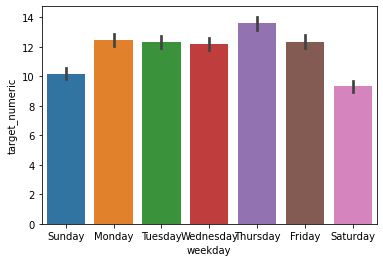

In [13]:
sns.barplot(x= df.weekday, y=df.target_numeric)

<AxesSubplot:xlabel='month', ylabel='target_numeric'>

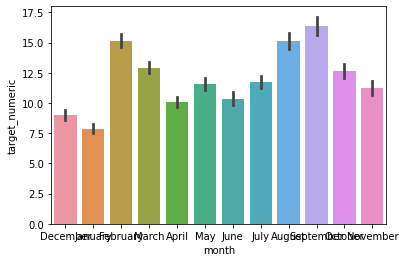

In [14]:
sns.barplot(x= df.month, y=df.target_numeric)

# SAVE DATA

In [105]:
#df.merge(df.groupby('zugnr').mean('target_numeric'))
#sns.histplot(df.groupby('zugnr').mean('target_numeric')['target_numeric'])

df = df[['zugnr', 'trip', 'city',  'bhf', 
    'date', 'datum', 'sharp_date', 'weekday', 'month', 'time_of_day',
    'arrTime_clean','adelay','target', 'target_binary','target_numeric','target_good_bad',
    'temp', 'prcp', 'snow', 'wspd', 'wpgt', 'coco']]

In [106]:
df.to_csv('../goodtrainbadtrain/data/data_for_model_legs.csv')